In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import scipy.integrate as integrate

import torch
import torchquad


In [2]:
# may want to revisit these choices
integrator = torchquad.Trapezoid()
N_integrator = 101

In [3]:
# ansatz helper functions

# g_coeffs: M x N matrix such that g = sum_{m, n} g_mn t^n alpha ^m
    # 1st row is g* term

def g(t, alpha, g_coeffs, mstar):
    M,N = g_coeffs.shape
    g_star = alpha**mstar * sum([g_coeffs[0,n]*torch.pow(t,n) for n in range(N) ])
    g_higher = sum([alpha**(mstar + m) * g_coeffs[m,n]*torch.pow(t,n) for n in range(N) for m in range(1,M) ])
    return -torch.log(g_star) + g_higher


def q(t, alpha, g_coeffs, mstar):
    def f(t):
        return torch.exp(-g(t, alpha, g_coeffs, mstar))
    
    intfunc = lambda tt: integrator.integrate(f, dim=1, N=N_integrator, integration_domain=[[0, tt]])

    # vmap does not like the torch integrator but it's running decently quickly now...
    #vec_int = torch.func.vmap(intfunc)
    #exp_term = vec_int(t)

    exp_term = torch.tensor([intfunc(tt) for tt in t])

    return f(t)*torch.exp(-exp_term)


/global/homes/r/rmastand/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/global/homes/r/rmastand/.local/lib/python3.8/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


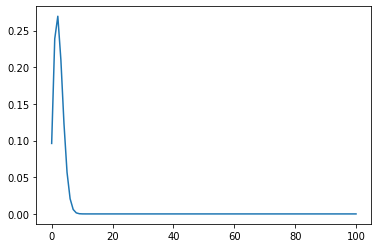

In [4]:

g_coeffs = torch.tensor(np.array([[1, 2, 0], [4,0,0]]))
t = torch.linspace(0, 100, 100)


plt.figure()
plt.plot(t, q(t, 0.1, g_coeffs, 1))
plt.show()

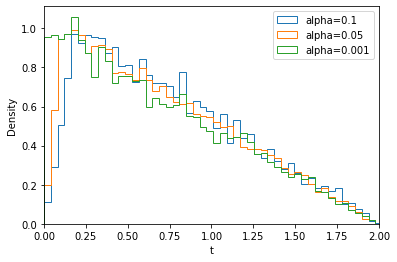

In [10]:
# choose data distribution

def get_data(N, alpha):

    #return np.random.exponential(size=N, scale = (0.2 + alpha))

    return np.random.triangular(size = N, left = 0, right = 2, mode = 2*alpha)

    #x = np.linspace(3, 7, N)
    #delta = np.random.uniform(-1, 1, x.size)
    #y = 0.4*x + delta

    return y


plt.figure()
for alpha in [0.1, 0.05, 0.001]:
    plt.hist( get_data(10000, alpha), bins = np.linspace(0, 4, 100), histtype = "step", label = f"alpha={alpha}", density = True)
plt.legend()
plt.xlim(0, 2)
plt.xlabel("t")
plt.ylabel("Density")
plt.show()

In [15]:
# Initialize the g_coefficients

mstar = 1
g_coeffs_to_fit = torch.rand(size=(3,3)).float()
print(g_coeffs_to_fit)

tensor([[0.4432, 0.7259, 0.2335],
        [0.7436, 0.7176, 0.2905],
        [0.2841, 0.3870, 0.3185]])


In [17]:
from torch.autograd.functional import jacobian


epochs = 5000


N_data = 20000 # number of data samples per epoch to draw
t_bins = torch.linspace(0, 2, 40)
t_bin_centers = 0.5*(t_bins[1:] + t_bins[:-1])
delta_alpha = 0.001

def train(epochs, lr = 1e-3, lambda_=1):

    g_coeffs_to_fit.requires_grad_()
    optimizer = torch.optim.AdamW([g_coeffs_to_fit], lr=lr)

    MSE_criterion = torch.nn.MSELoss()

    losses_MSE, losses_deriv = [], []

    for epoch in  tqdm(range(epochs)):

        optimizer.zero_grad()

        # generate a random alpha for the epoch
        reroll = True
        while reroll:
            # alpha = torch.distributions.Exponential(1 / 0.118).sample()
            loc_alpha = torch.distributions.Exponential(1 / 0.118).sample((1,))
            # alpha = torch.rand(batch_conditional)
            if (loc_alpha > 0.001) and (loc_alpha < 1):
                reroll = False

        # define another random alpha for the derivative
        loc_alpha_prime = loc_alpha + delta_alpha 
        
        # calculate ansatz
        loc_ansatz = q(t_bin_centers, loc_alpha, g_coeffs_to_fit, mstar)

        # generate training data
        loc_data = get_data(N_data, loc_alpha)
        loc_data_prime = get_data(N_data, loc_alpha_prime)
        # histogram
        loc_data_pdf, _ = np.histogram(loc_data, bins = t_bins, density = True)
        loc_data_pdf_prime, _ = np.histogram(loc_data_prime, bins = t_bins, density = True)

        """
        plt.figure()
        plt.hist(loc_data, bins = t_bins, density = True)
        plt.plot(t_bin_centers.detach().cpu().numpy(), loc_data_pdf)
        plt.plot(t_bin_centers.detach().cpu().numpy(), loc_ansatz.detach().cpu().numpy())
        plt.title(loc_alpha)
        plt.show()
        """

        loc_data_pdf = torch.tensor(loc_data_pdf)
        loc_data_pdf_prime = torch.tensor(loc_data_pdf_prime)

        # calculate MSE loss
        loss_MSE = MSE_criterion(loc_data_pdf.float(), loc_ansatz.float())

        # calculate derivative loss
        # TODO: maybe this should only be done if alpha is small?
        helper_ansatz = lambda a: q(t_bin_centers, a, g_coeffs_to_fit, mstar)

        # TODO: higher derivatives
        q_deriv = torch.autograd.functional.jacobian(helper_ansatz, loc_alpha, create_graph=False, strict=False, vectorize=False, strategy='reverse-mode').reshape(-1,)
        data_deriv = (loc_data_pdf_prime - loc_data_pdf) / (delta_alpha)

        loss_deriv = MSE_criterion(q_deriv.float(), data_deriv.float())

        loss = loss_MSE + lambda_*loss_deriv

        loss.backward()
        optimizer.step()

        losses_MSE.append(loss_MSE.detach().cpu().numpy())
        losses_deriv.append(loss_deriv.detach().cpu().numpy())



    return losses_MSE, losses_deriv

losses_MSE, losses_deriv = train(epochs, lr = 1e-2, lambda_ = 1)


100%|██████████| 5000/5000 [06:53<00:00, 12.09it/s]


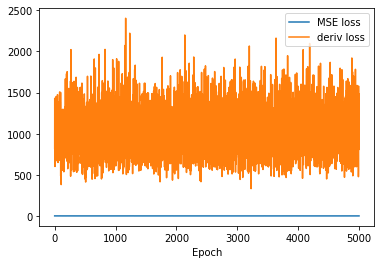

In [18]:
plt.figure()

plt.plot(losses_MSE, label = "MSE loss")
plt.plot(losses_deriv, label = "deriv loss")
plt.legend()

plt.xlabel("Epoch")


plt.show()

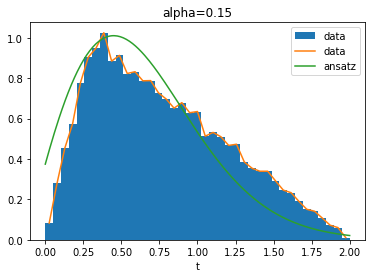

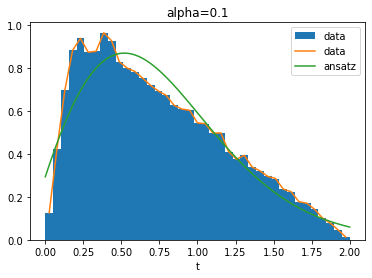

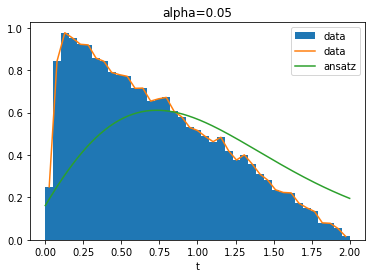

In [19]:
for alpha in [0.15, 0.1, 0.05]:
    
     
    # generate training data
    loc_data = get_data(N_data, alpha)
    # histogram
    loc_data_pdf, _ = np.histogram(loc_data, bins = t_bins, density = True)
    
    
    
    tt = torch.linspace(0, 2, 200)
    loc_ansatz = q(tt , alpha, g_coeffs_to_fit, mstar)
    
    plt.figure()
    plt.hist(loc_data, bins = t_bins, density = True, label = "data")
    plt.plot(t_bin_centers.detach().cpu().numpy(), loc_data_pdf, label = "data")
    plt.plot(tt , loc_ansatz.detach().cpu().numpy(), label = "ansatz")
    plt.legend()
    plt.xlabel("t")
    plt.title(f"alpha={alpha}")
    plt.show()

In [20]:
print(g_coeffs_to_fit)

tensor([[ 3.3357, 25.3447, -5.4427],
        [12.3214, -2.5464, -0.9237],
        [ 3.7478, -0.4534,  1.4320]], requires_grad=True)
